# **Import Necessary Modules & Package**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import sklearn
import cv2

# **Upload Dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_folder = '/content/drive/MyDrive/CAPSTONE_PROJECT/ML/Dataset'
os.listdir(dataset_folder)

['Digital_English_Font.zip', 'Mutasi_Rekening', 'Dataset-English-Font.zip']

In [ ]:
# Define the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/CAPSTONE_PROJECT/ML/Dataset/Dataset-English-Font.zip'

# Define the folder in Colab where you want to extract the files (inside the local /content/ folder)
extract_folder = '/content/'

# Make sure the extract folder exists, if not, create it
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully to /content/extracted_data/!")

Zip file extracted successfully to /content/extracted_data/!


In [ ]:
DATASET = '/content/English/Fnt'

# **Check the Dataset for Training**

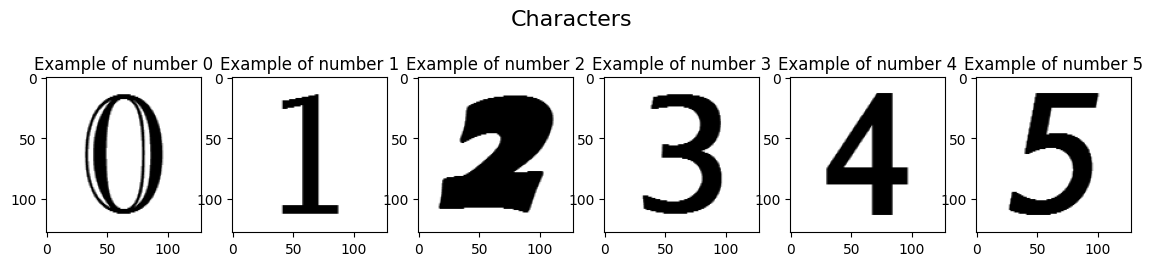

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(14, 3))
fig.suptitle('Characters', fontsize=16)

# Plot one image from the first 4 letters
for ii, filesname in enumerate(['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006']):
    dir = f'/content/English/Fnt/{filesname}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of number {ii}')

#Kayaknya prefer ngerename folder yang ada foto2nya gasii? kayak misal folder Sample001 kan isinya foto dari angka 0 yaa
#Kita rename aja folder nya jadi 0. Tolong pendapatnya ya guys

In [ ]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")
sample_array[0,:5]

Each image has shape: (128, 128, 3)


array([[255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.]], dtype=float32)

# **Set the Hyperparameter**

In [ ]:
#Hyperparameter
BATCH_SIZE = 64
IMG_HEIGHT = 28
IMG_WIDTH = 28
LEARNING_RATE = 0.1
EPOCHS = 20

# **Create and Split the Dataset**

In [ ]:
def train_val_datasets():

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATASET,
        image_size=(IMG_HEIGHT,IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        color_mode='grayscale',
        validation_split=0.2,
        subset='both',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
list_label = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
training_dataset, validation_dataset = train_val_datasets()

Found 63178 files belonging to 62 classes.
Using 50543 files for training.
Using 12635 files for validation.


# **Rescale the Dataset & Apply Prefetch to the Training Dataset**

In [ ]:
def rescale_image(image, label) :
  return image/255, label

training_dataset = training_dataset.map(rescale_image)
validation_dataset = validation_dataset.map(rescale_image)

In [ ]:
# Apply prefetch for performance optimization on training dataset
training_dataset = training_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Apply prefetch for performance optimization on validation dataset
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# **Recheck the Training and Validation Dataset**

In [ ]:
print(f"training dataset have shape: {type(training_dataset)}")
print(f"Images of training dataset have shape: {training_dataset.element_spec[0].shape}")
print(f"Labels of training dataset have shape: {training_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}\n")

for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

training dataset have shape: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Images of training dataset have shape: (None, 28, 28, 1)
Labels of training dataset have shape: (None, 62)
Images of validation dataset have shape: (None, 28, 28, 1)
Labels of validation dataset have shape: (None, 62)

Maximum pixel value of images: 1.0

Shape of batch of images: (64, 28, 28, 1)
Shape of batch of labels: (64, 62)


# **Create, Compile, Check Compatibility, and Train the OCR Model**

In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))

# Block 1
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# Block 2
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# Block 3
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# Block 4
x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# Flatten and Dense layers with added dropout
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(62, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Check input & Output shape
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')
# Summary of the updated model
model.summary()

Input shape: (None, 28, 28, 1)
Output shape: (None, 62)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,730,174 (6.60 MB)

 Trainable params: 1,728,254 (6.59 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (64, 62)


In [ ]:
# Train your model
history = model.fit(training_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    )

Epoch 1/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 507s 641ms/step - accuracy: 0.3967 - loss: 2.2834 - val_accuracy: 0.7854 - val_loss: 0.6222
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 536s 609ms/step - accuracy: 0.7828 - loss: 0.6344 - val_accuracy: 0.8293 - val_loss: 0.4517
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 479s 606ms/step - accuracy: 0.8201 - loss: 0.4911 - val_accuracy: 0.8446 - val_loss: 0.4041
Epoch 4/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 479s 606ms/step - accuracy: 0.8456 - loss: 0.4139 - val_accuracy: 0.8469 - val_loss: 0.4426
Epoch 5/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 491s 621ms/step - accuracy: 0.8600 - loss: 0.3599 - val_accuracy: 0.8667 - val_loss: 0.3528
Epoch 6/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 480s 608ms/step - accuracy: 0.8742 - loss: 0.3293 - val_accuracy: 0.8667 - val_loss: 0.3505
Epoch 7/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 501s 606ms/step - accuracy: 0.8832 - loss: 0.3016 - val_accuracy: 0.8708 - val_loss: 0.3682
Epoch 8/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 498s 630ms/step - accuracy: 0.8905 -

# **Evaluate OCR Model**

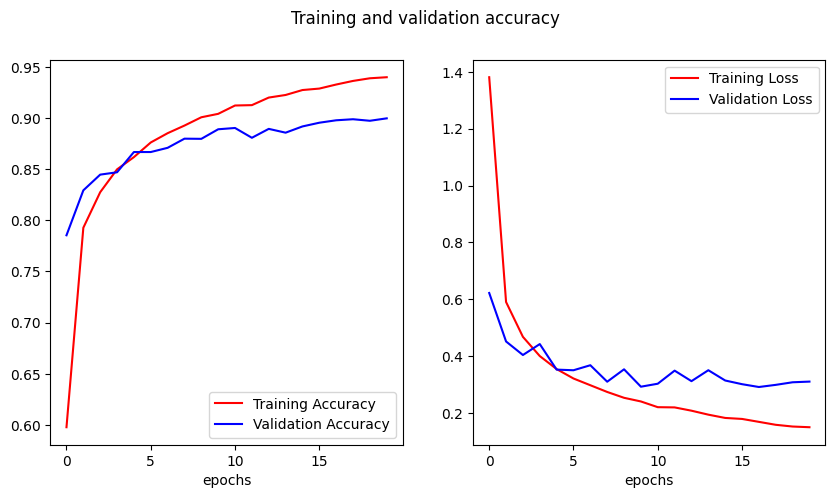

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

# **Check Result of Each Label in the Validation Dataset**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Prepare validation data and labels
val_images = []
val_labels = []

for images, labels in validation_dataset:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict on the validation dataset
predictions = model.predict(val_images, batch_size=BATCH_SIZE)

list_label_1 = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')


# Generate classification report
print(classification_report(
    val_labels.argmax(axis=1),  # True labels
    predictions.argmax(axis=1),  # Predicted labels
    target_names=list_label_1
))


198/198 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       208
           1       0.97      0.86      0.91       217
           2       0.98      1.00      0.99       195
           3       0.97      0.99      0.98       206
           4       1.00      0.98      0.99       207
           5       1.00      1.00      1.00       214
           6       0.99      1.00      0.99       203
           7       0.97      0.98      0.98       189
           8       0.98      0.98      0.98       203
           9       0.96      0.99      0.98       200
           A       0.97      0.95      0.96       236
           B       0.92      0.97      0.94       213
           C       0.85      0.72      0.78       195
           D       0.93      0.97      0.95       209
           E       0.97      0.91      0.94       190
           F       0.97      0.95      0.96       204
           G       0.96      0.97    

# **Save the OCR Model**

In [ ]:
model.save('my_model_3.h5')

In [ ]:
model.save('my_model_3.keras')

In [ ]:
model.save_weights('my_model_3.weights.h5')

In [ ]:
from google.colab import files
files.download('my_model_3.keras')
files.download('my_model_3.h5')
files.download('my_model_3.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>